# Сборный проект —2

Описание проекта

Позади много уроков и заданий, и закрепить свои знания, как обычно, вы сможете в самостоятельном проекте. Это непростой проект, в котором от вас потребуется больше самостоятельности. Этапы работы описаны кратко, и вам понадобится декомпозировать задачи, то есть разделить их на более мелкие. Опирайтесь на знания об этапах анализа данных и машинного обучения из прошлых курсов.

Перейдём к задаче. HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 

Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли. 

1. У вас будет несколько задач. Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
- Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.
2. Ваша вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

**Для этой задачи заказчик предоставил данные с признаками:**

- id — уникальный идентификатор сотрудника;
- dept — отдел, в котором работает сотрудник;
- level — уровень занимаемой должности;
- workload — уровень загруженности сотрудника;
- employment_years — длительность работы в компании (в годах);
- last_year_promo — показывает, было ли повышение за последний год;
- last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
- supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
- salary — ежемесячная зарплата сотрудника;
- job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.

In [1]:
#!pip install phik -q # -q убирает необязательные выводы в командах Linux
#!pip install shap
#!pip install --upgrade shap
#!pip install --upgrade numba
#!pip install seaborn==0.13.2
!pip install imbalanced-learn==0.10.1
#!pip install scikit-learn==1.2.2
!pip install xgboost lightgbm

In [2]:
import pandas as pd
import numpy as np
from math import *
import plotly.express as px
import scipy.stats as st

import matplotlib.pyplot as plt
import seaborn as sns

import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix

from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV, train_test_split

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor 

import shap
from sklearn.metrics import make_scorer

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

#from imblearn.over_sampling import RandomOverSampler
from sklearn.inspection import permutation_importance

## Задача 1

In [3]:
try:
    #Тренировочная выборка:
    train_job_satisfaction_rate = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
    train_job_satisfaction_rate.name = 'train_job_satisfaction_rate'
    #Входные признаки тестовой выборки:
    test_features = pd.read_csv('/datasets/test_features.csv')
    test_features.name = 'test_features'
    #Целевой признак тестовой выборки:
    test_target_job_satisfaction_rate = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')
    test_target_job_satisfaction_rate.name = 'test_target_job_satisfaction_rate'
except:
    #Тренировочная выборка:
    train_job_satisfaction_rate = pd.read_csv('train_job_satisfaction_rate.csv')
    train_job_satisfaction_rate.name = 'train_job_satisfaction_rate'
    #Входные признаки тестовой выборки:
    test_features = pd.read_csv('test_features.csv')
    test_features.name = 'test_features'
    #Целевой признак тестовой выборки:
    test_target_job_satisfaction_rate = pd.read_csv('test_target_job_satisfaction_rate.csv')
    test_target_job_satisfaction_rate.name = 'test_target_job_satisfaction_rate'

In [4]:
all_data_list = [train_job_satisfaction_rate,test_features,test_target_job_satisfaction_rate]

In [5]:
for i in all_data_list:
    display(i.name)
    display(i.head())

'train_job_satisfaction_rate'

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


'test_features'

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


'test_target_job_satisfaction_rate'

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


Таблицы выглядят хорошо, ничего не исправляем

In [6]:
for i in all_data_list:
    print(i.name)
    print(' ')
    i.info()
    print(' ')

train_job_satisfaction_rate
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB
 
test_features
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 


Во всех таблицах правильный тип данных

### Предобработка данных

#### Замените названия столбцов (приведите к нижнему регистру)

In [7]:
def to_lower(all_data_list):
    for i in all_data_list:
        i.columns = i.columns.str.lower().str.replace(' ', '_')
to_lower(all_data_list)

Привели к змеиному регистру

#### Обработайте пропуски при необходимости

In [8]:
for i in all_data_list:
    print(' ')
    print(i.name)
    print(' ')
    print(i.isna().sum())

 
train_job_satisfaction_rate
 
id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64
 
test_features
 
id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64
 
test_target_job_satisfaction_rate
 
id                       0
job_satisfaction_rate    0
dtype: int64


Видим 10 пропусков в таблице - train_job_satisfaction_rate и 3 пропуска в test_features. **Если есть пропуски, заполните их в пайплайне.**

#### Дубликаты

In [9]:
for i in all_data_list:
    print(' ')
    print(i.name)
    print(' ')
    print(i.duplicated().sum())

 
train_job_satisfaction_rate
 
0
 
test_features
 
0
 
test_target_job_satisfaction_rate
 
0


Явных дубликатов - нет

In [10]:
for i in all_data_list:
    print(' ')
    print(i.name)
    print(' ')
    for column in i.select_dtypes(include='object').columns:
        print(column)
        print(i[column].unique())

 
train_job_satisfaction_rate
 
dept
['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
level
['junior' 'middle' 'sinior' nan]
workload
['medium' 'high' 'low']
last_year_promo
['no' 'yes']
last_year_violations
['no' 'yes']
 
test_features
 
dept
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
level
['junior' 'middle' 'sinior' nan]
workload
['medium' 'low' 'high' ' ']
last_year_promo
['no' 'yes']
last_year_violations
['no' 'yes']
 
test_target_job_satisfaction_rate
 


заменим значения ' ' - на nan

In [11]:
test_features['dept'] = test_features['dept'].replace(' ',np.nan)
test_features['workload'] = test_features['workload'].replace(' ',np.nan)

Вывод:
- Привели к змеиному регистру
- Явных дубликатов - нет
- заменили значения ' ' - на nan
- Видим 10 пропусков в таблице - train_job_satisfaction_rate и 3 пропуска в test_features. Если есть пропуски, заполните их в пайплайне.

### Исследовательский анализ данных

In [12]:
train_job_satisfaction_rate.set_index('id', inplace=True)
train_job_satisfaction_rate.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76
184592,sales,junior,low,1,no,no,2,12000,0.11
171431,technology,junior,low,4,no,no,2,18000,0.37
693419,hr,junior,medium,1,no,no,3,22800,0.20


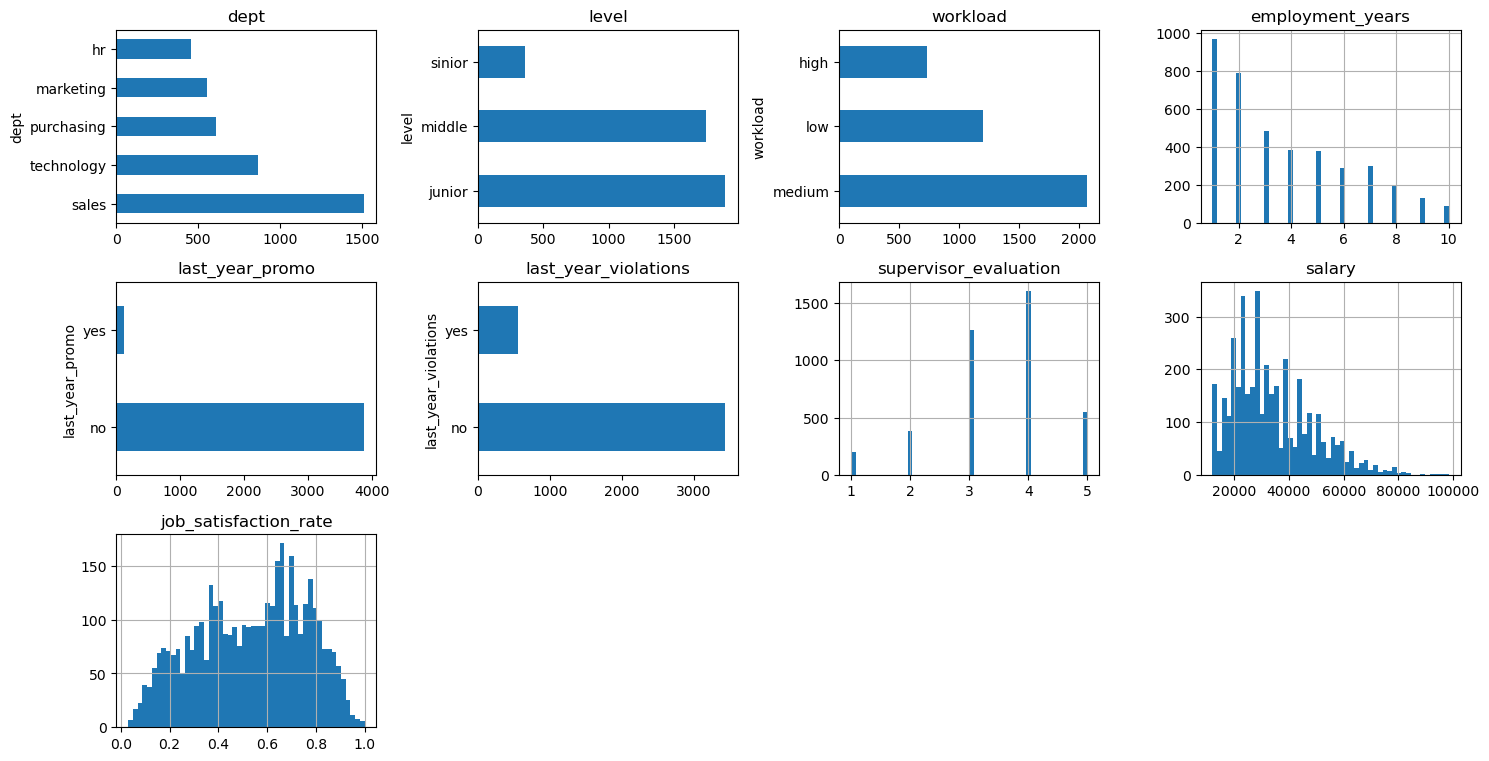

In [13]:
fig = plt.figure(figsize=(15, 10)) 
for i,column in enumerate(train_job_satisfaction_rate.columns):
    ax = fig.add_subplot(4, 4, i + 1)
    if train_job_satisfaction_rate[column].dtype == 'object':
        train_job_satisfaction_rate[column].value_counts().plot(kind='barh')
        ax.set_title(column)
    else:
        train_job_satisfaction_rate[column].hist(bins = 50)
        ax.set_title(column)
plt.tight_layout()  # Автоматически подгоняем размер подграфиков для лучшей компоновки
plt.show()  # Отображаем графики

Аномальных значений пока не видим

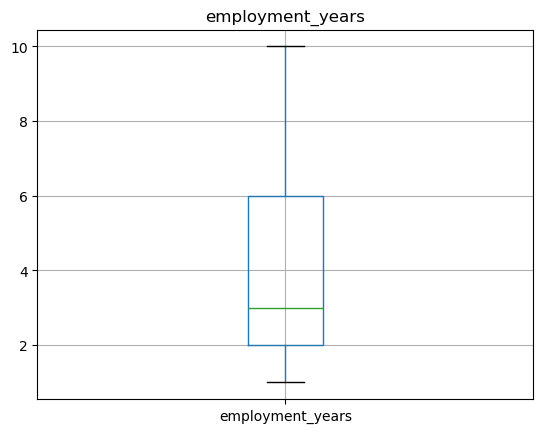

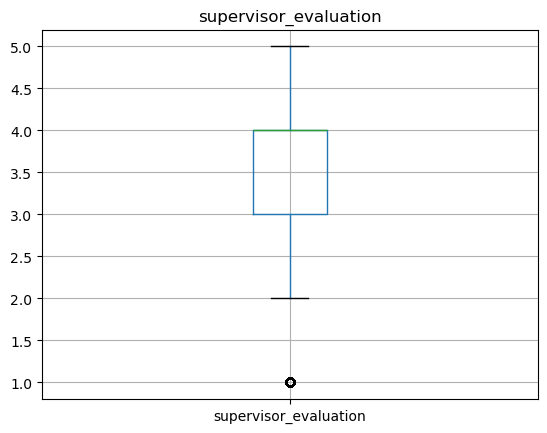

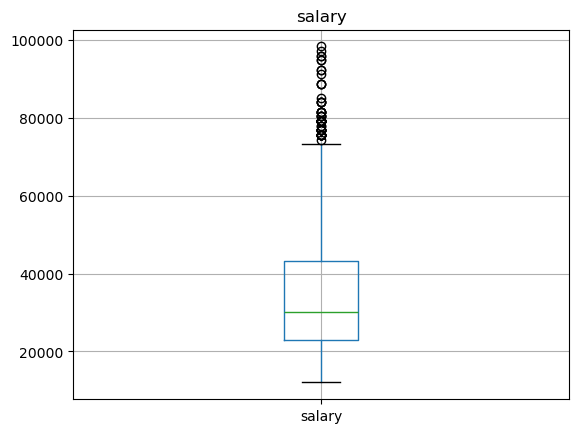

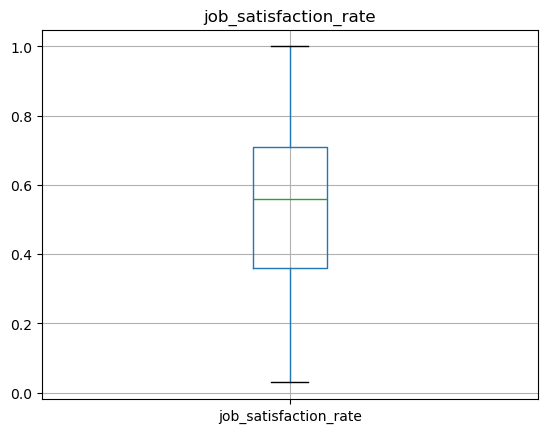

In [14]:
for column in train_job_satisfaction_rate.columns:
    if train_job_satisfaction_rate[column].dtype != 'object' :
        train_job_satisfaction_rate.boxplot(column)
        plt.title(column)
        plt.show()

Аномальных значений не видим, выбросов тоже, просто большая зарплата

In [15]:
train_job_satisfaction_rate.describe()

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,3.718500,3.476500,33926.700000,0.533995
std,2.542513,1.008812,14900.703838,0.225327
min,1.000000,1.000000,12000.000000,0.030000
25%,2.000000,3.000000,22800.000000,0.360000
50%,3.000000,4.000000,30000.000000,0.560000
75%,6.000000,4.000000,43200.000000,0.710000
max,10.000000,5.000000,98400.000000,1.000000


In [16]:
test_features.set_index('id', inplace=True)
test_features.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800
686555,hr,junior,medium,1,no,no,4,30000
467458,sales,middle,low,5,no,no,4,19200
418655,sales,middle,low,6,no,no,4,19200
789145,hr,middle,medium,5,no,no,5,40800


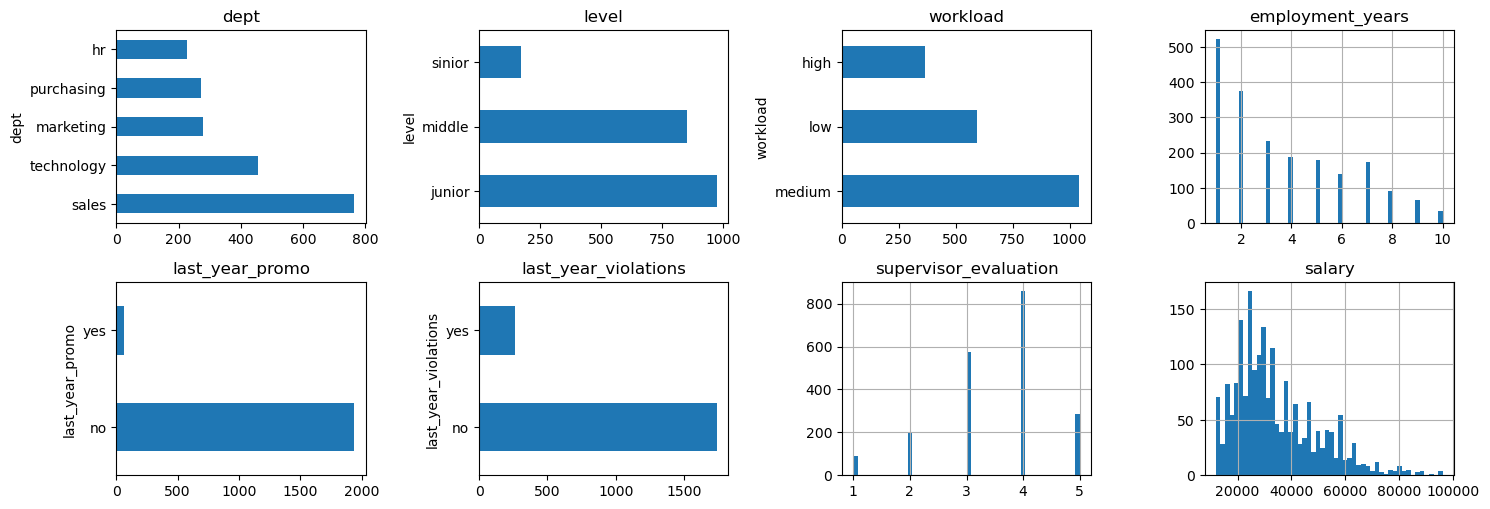

In [17]:
fig = plt.figure(figsize=(15, 10))

for i,column in enumerate(test_features.columns):
    ax = fig.add_subplot(4, 4, i + 1)
    if test_features[column].dtype == 'object':
        test_features[column].value_counts().plot(kind='barh')
        ax.set_title(column)
    else:
        test_features[column].hist(bins = 50)
        ax.set_title(column)
plt.tight_layout();
plt.show();

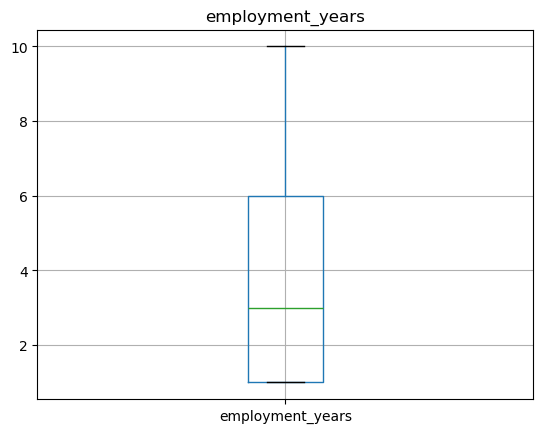

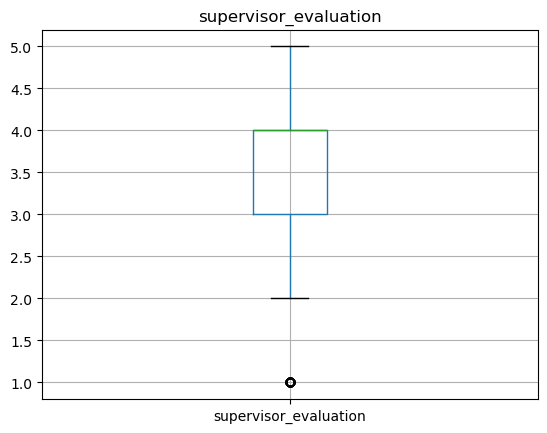

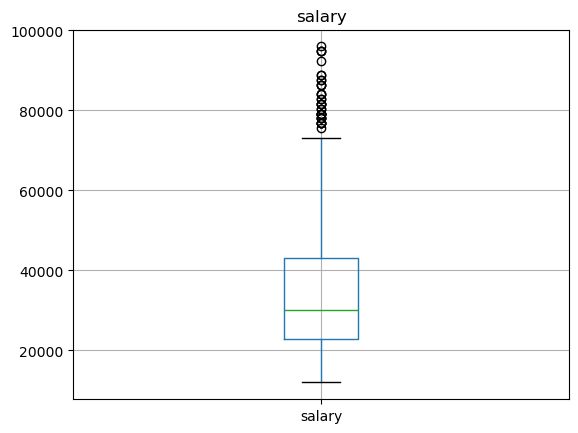

In [18]:
for column in test_features.columns:
    if test_features[column].dtype != 'object' :
        test_features.boxplot(column)
        plt.title(column)
        plt.show()

In [19]:
test_features.describe()

,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000
mean,3.666500,3.526500,34066.800000
std,2.537222,0.996892,15398.436729
min,1.000000,1.000000,12000.000000
25%,1.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


In [20]:
test_target_job_satisfaction_rate.set_index('id', inplace=True)
test_target_job_satisfaction_rate.head()

,job_satisfaction_rate
id,
130604,0.74
825977,0.75
418490,0.60
555320,0.72
826430,0.08


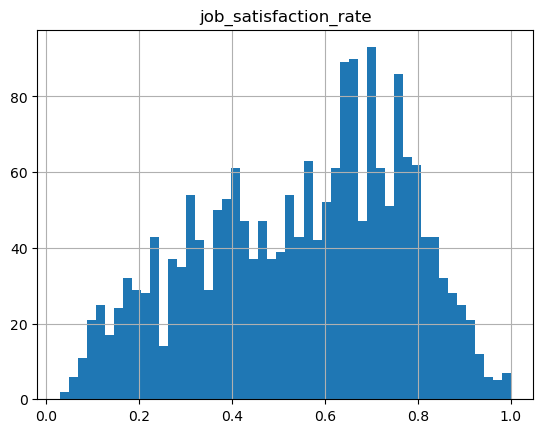

In [21]:
test_target_job_satisfaction_rate.hist(bins = 50)
plt.title('job_satisfaction_rate')
plt.show()

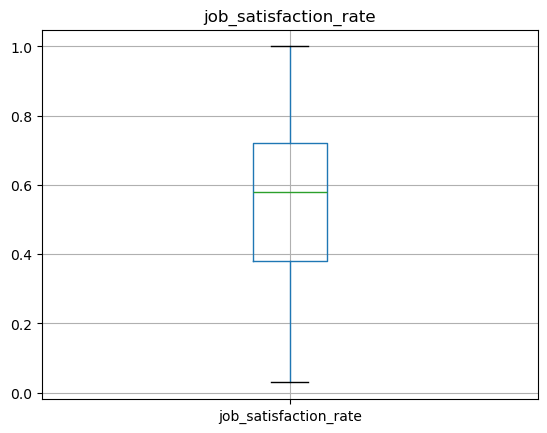

In [22]:
test_target_job_satisfaction_rate.boxplot()
plt.title('job_satisfaction_rate')
plt.show()

In [23]:
test_target_job_satisfaction_rate.describe()

,job_satisfaction_rate
count,2000.00000
mean,0.54878
std,0.22011
min,0.03000
25%,0.38000
50%,0.58000
75%,0.72000
max,1.00000


Вывод:
- аномальных значений - нет
- используем ohe,ord - для dept
- для num и float - StandardScaler(), MinMaxScaler(),RobustScaler()

### Корреляционный анализ 

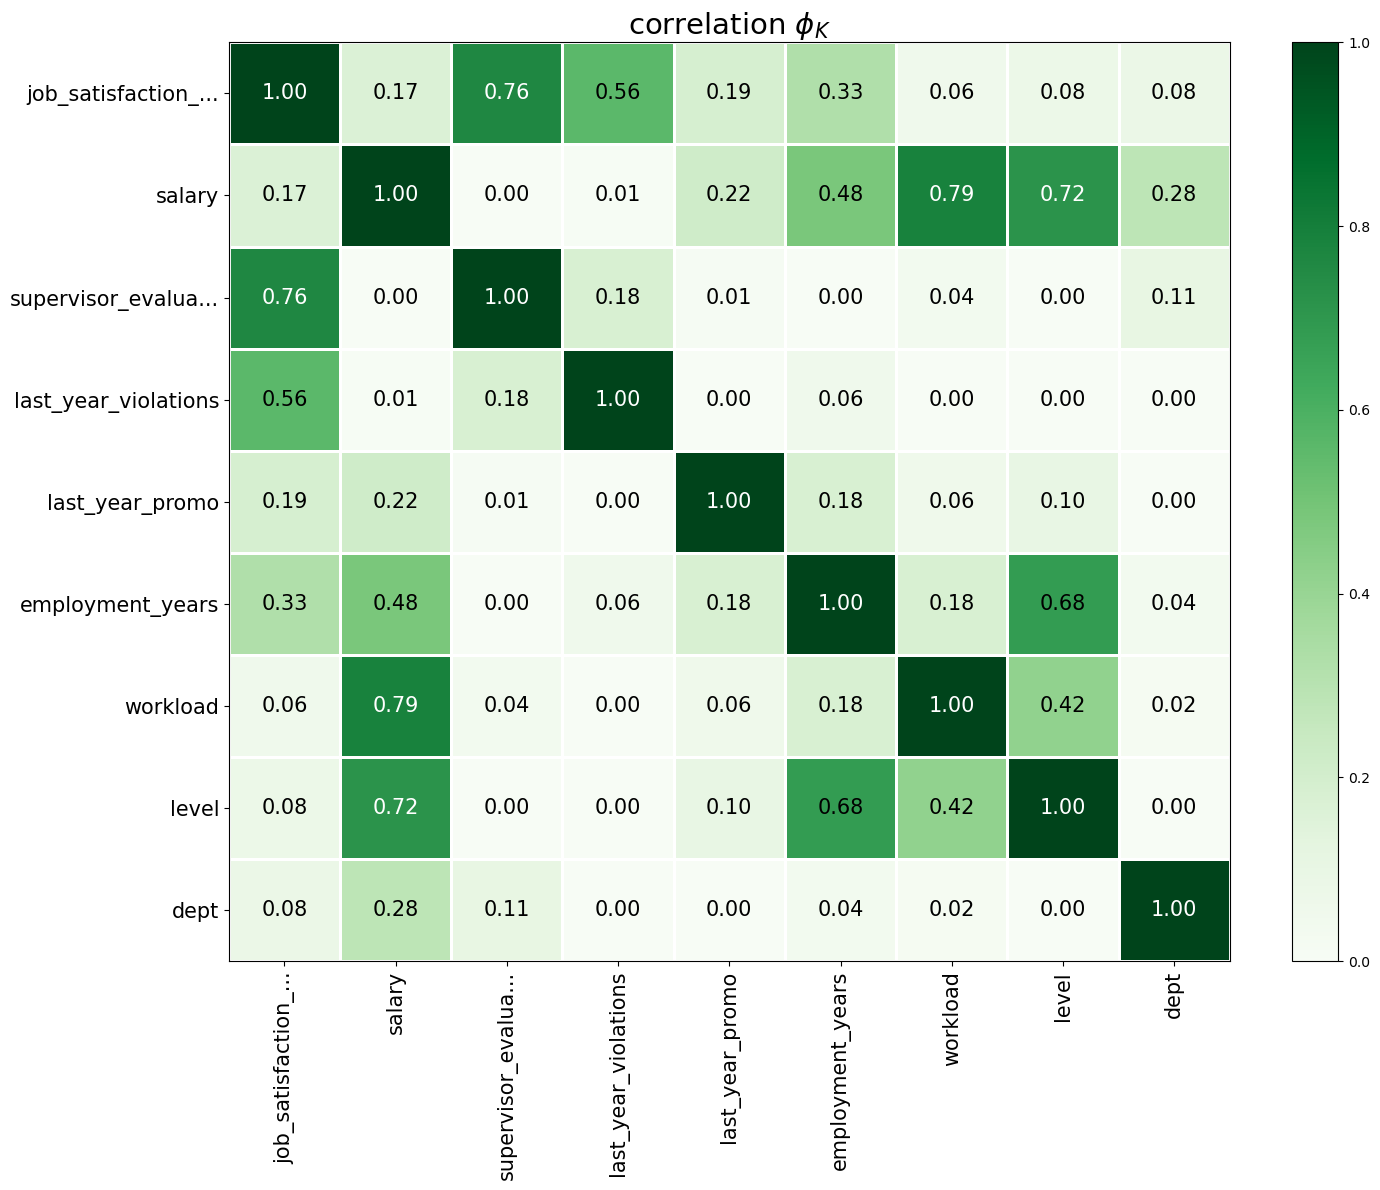

In [24]:
interval_cols = train_job_satisfaction_rate.select_dtypes(include = ['int','float'])

phik_overview = train_job_satisfaction_rate.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    vmin=0, vmax=1, color_map='Greens',
    fontsize_factor=1.5,
    figsize=(15, 12)
)

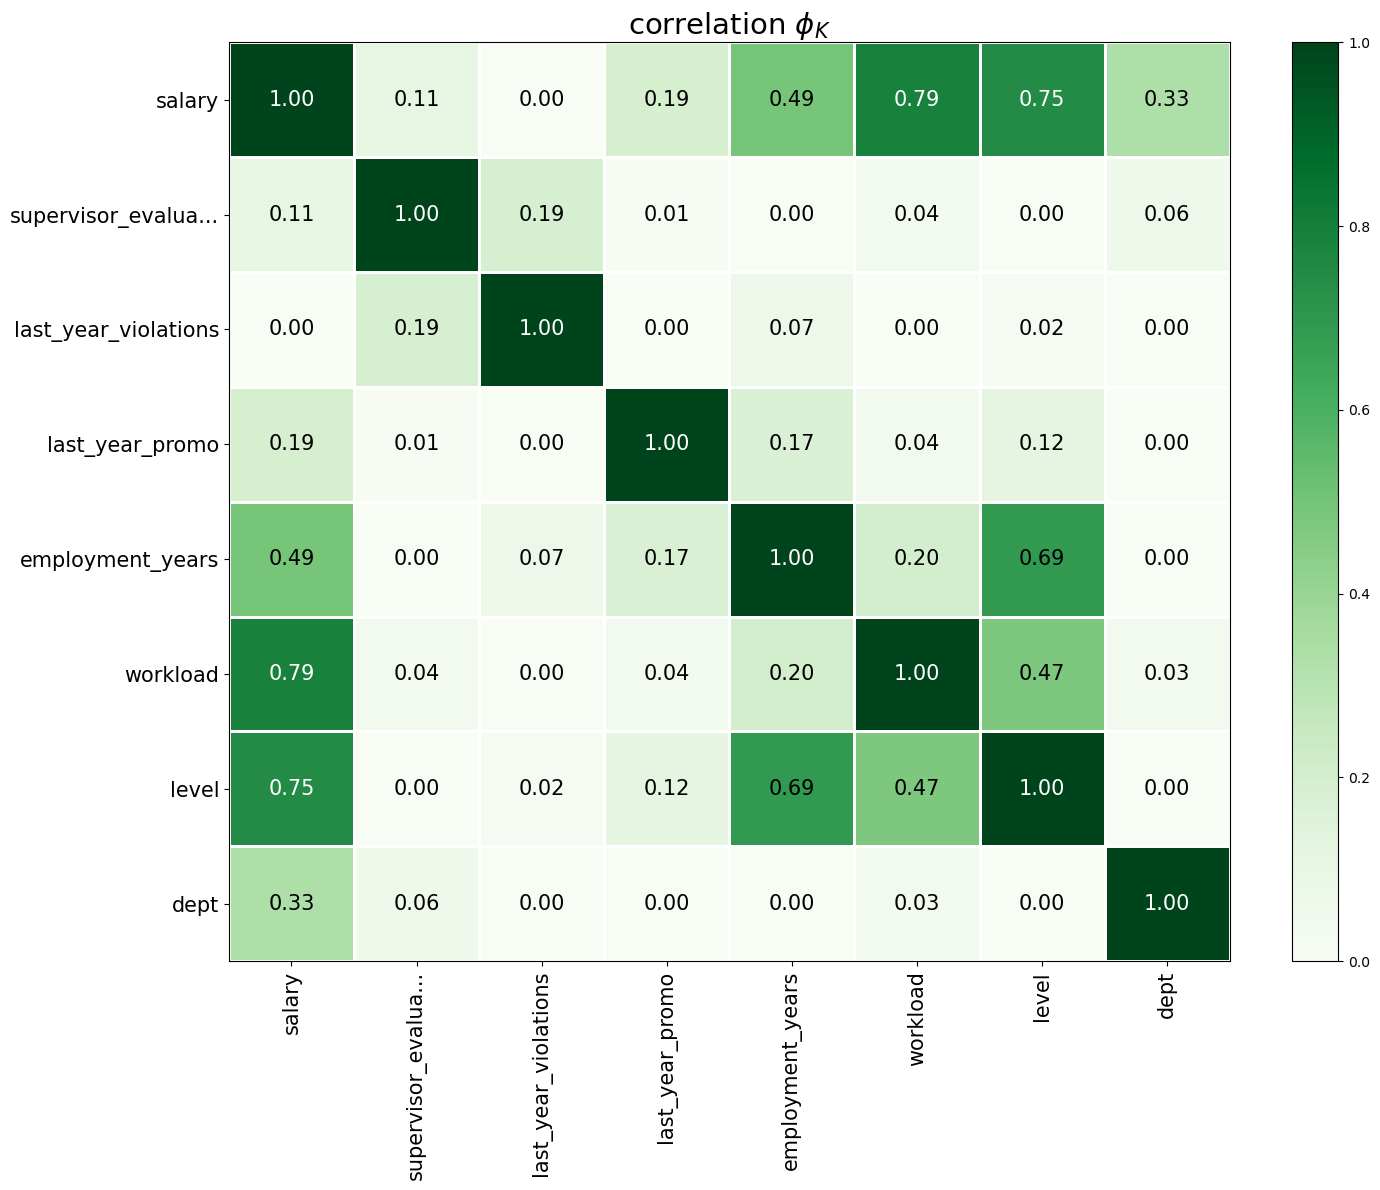

In [25]:
interval_cols = test_features.select_dtypes(include = ['int','float'])

phik_overview = test_features.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    vmin=0, vmax=1, color_map='Greens',
    fontsize_factor=1.5,
    figsize=(15, 12)
)

Мультиколлинеарности нет

### Подготовка данных

In [26]:

RANDOM_STATE = 42

X_train = train_job_satisfaction_rate.drop(['job_satisfaction_rate'], axis=1)
y_train = train_job_satisfaction_rate['job_satisfaction_rate']

test = test_target_job_satisfaction_rate.merge(test_features,on = 'id')
X_test = test.drop(['job_satisfaction_rate'], axis = 1)
y_test = test['job_satisfaction_rate']


# Создаём списки с названиями признаков
ohe_columns = [col for col in X_train.select_dtypes(include = 'object').columns.tolist() if (col != 'dept')]
ord_columns = ['dept']
num_columns = [col for col in X_train.select_dtypes(include = ['int','float']).columns.tolist() if (col != 'dept')]

# Создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
      ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore',sparse_output= False))])

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord', OrdinalEncoder(categories = [['sales', 'hr', 'technology', 'purchasing', 'marketing']],
                            handle_unknown='use_encoded_value',unknown_value = np.nan)),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))])

# Создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)], remainder='passthrough')

# Создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor())
])

param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)], 
        'models__max_depth': range(2, 15),
        'models__max_features': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
    },
   #{
   #    'models': [ElasticNet()],
   #    'models__alpha': [0.1, 1, 10], # Параметр регуляризации для ElasticNet
   #    'models__l1_ratio': [0.1, 0.5, 0.9], # Соотношение L1 и L2 регуляризации
   #    'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
   #},
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
    },
    {
        'models': [KNeighborsRegressor()],
        'models__n_neighbors': range(2, 15),
        'models__p': [1, 2], # Добавлен p=3 (Манхэттенская метрика)
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
    },
   #{
   #    'models': [SVR(kernel='linear')],
   #    'models__C': range(1, 10),
   #    'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
   #},
]

### Обучение моделей

In [27]:
def smape(y_true, y_pred):
    error = np.abs(y_true - y_pred)
    scale = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(error / scale) * 100
smape_scorer = make_scorer(smape, greater_is_better=False)

# Выполняем перекрёстную проверку с рандомизированным поиском
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=6,
    scoring=smape_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', np.abs(randomized_search.best_score_))
y_test_pred = randomized_search.predict(X_test)
print('SMAPE для тестовых данных:', smape(y_test,y_test_pred))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['level', 'workload',
                                                   'last_year_promo',
                                                   'last_year_violations']),
                     

In [28]:
results_df = pd.DataFrame(randomized_search.cv_results_).sort_values(by='rank_test_score').set_index('params')
results_df.iloc[:, 4:]

,param_preprocessor__num,param_models__max_features,param_models__max_depth,param_models,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
params,,,,,,,,,,,,,
"{'preprocessor__num': RobustScaler(), 'models__max_features': 8, 'models__max_depth': 13, 'models': DecisionTreeRegressor(random_state=42)}",RobustScaler(),8,13,DecisionTreeRegressor(random_state=42),-16.277672,-14.951930,-15.442038,-15.135904,-15.482477,-14.793843,-15.347311,0.483074,1
"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 7, 'models__max_depth': 13, 'models': DecisionTreeRegressor(random_state=42)}",MinMaxScaler(),7,13,DecisionTreeRegressor(random_state=42),-16.863607,-15.301461,-15.683832,-15.421887,-15.400944,-15.291175,-15.660484,0.553418,2
"{'preprocessor__num': RobustScaler(), 'models__max_features': 6, 'models__max_depth': 13, 'models': DecisionTreeRegressor(random_state=42)}",RobustScaler(),6,13,DecisionTreeRegressor(random_state=42),-17.382578,-15.112103,-15.462237,-15.927393,-15.545908,-15.393083,-15.803884,0.745891,3
"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 5, 'models__max_depth': 14, 'models': DecisionTreeRegressor(random_state=42)}",MinMaxScaler(),5,14,DecisionTreeRegressor(random_state=42),-16.395448,-16.204663,-16.977554,-16.997018,-15.845685,-14.870267,-16.215106,0.726912,4
"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 5, 'models__max_depth': 10, 'models': DecisionTreeRegressor(random_state=42)}",MinMaxScaler(),5,10,DecisionTreeRegressor(random_state=42),-17.089422,-16.475249,-17.030624,-17.665388,-16.797722,-16.066293,-16.854116,0.502008,5
"{'preprocessor__num': 'passthrough', 'models__max_features': 14, 'models__max_depth': 6, 'models': DecisionTreeRegressor(random_state=42)}",passthrough,14,6,DecisionTreeRegressor(random_state=42),-19.014379,-18.675951,-19.422770,-19.650768,-19.146603,-17.845254,-18.959288,0.584870,6
"{'preprocessor__num': StandardScaler(), 'models__max_features': 14, 'models__max_depth': 5, 'models': DecisionTreeRegressor(random_state=42)}",StandardScaler(),14,5,DecisionTreeRegressor(random_state=42),-20.422950,-19.230193,-20.496811,-21.053150,-20.304747,-18.906037,-20.068981,0.751500,7
"{'preprocessor__num': RobustScaler(), 'models__max_features': 6, 'models__max_depth': 5, 'models': DecisionTreeRegressor(random_state=42)}",RobustScaler(),6,5,DecisionTreeRegressor(random_state=42),-20.407582,-21.149879,-21.003798,-22.263217,-21.823962,-19.011666,-20.943351,1.047400,8
"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 2, 'models__max_depth': 6, 'models': DecisionTreeRegressor(random_state=42)}",MinMaxScaler(),2,6,DecisionTreeRegressor(random_state=42),-21.356373,-21.082618,-20.723664,-22.227241,-21.662857,-19.092382,-21.024189,0.982445,9


In [29]:
best_model = randomized_search.best_estimator_
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['level', 'workload',
                                                   'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleI...
                                                                   OrdinalEncoder(categories=[['sales',
                                                                                               'hr',
                                                                                               'technology',
                                                                                               'purchasing',
                                                                                               'marketing']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['dept']),
                                                 ('num', RobustScaler(),
                                                  ['employment_years',
                                                   'supervisor_evaluation',
                                                   'salary'])])),
                ('models',
                 DecisionTreeRegressor(max_depth=13, max_features=8,
                                       random_state=42))])

Лучше всего справилась модель - DecisionTreeRegressor(max_depth=13, max_features=8, random_state=42)

### Важность признаков

In [30]:
# Извлекаем шаги предобработки и моделирования из лучшего пайплайна
best_pipeline = randomized_search.best_estimator_
preprocessor = best_pipeline.named_steps['preprocessor']
model = best_pipeline.named_steps['models']
preprocessor_col = preprocessor.get_feature_names_out()

# Применяем шаги предобработки к обучающим данным
X_train_preprocessed = preprocessor.transform(X_train)
X_train_preprocessed = pd.DataFrame(X_train_preprocessed,columns = preprocessor_col)

# Выполняем перестановку признаков
result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=RANDOM_STATE)

# Сортируем по убыванию среднего значения важности
sorted_idx = result.importances_mean.argsort()[::-1]

# Выводим результаты
print("Важность признаков по перестановке:")
for i in sorted_idx:
    col = X_test.columns[i]
    corr = result.importances_mean[i]
    print(f"{col}: {corr:.4f}") 

Важность признаков по перестановке:
supervisor_evaluation: 1.1296
salary: 0.2661
employment_years: 0.2588
level: 0.2274
workload: 0.1551
last_year_violations: 0.1062
dept: 0.0914
last_year_promo: 0.0184


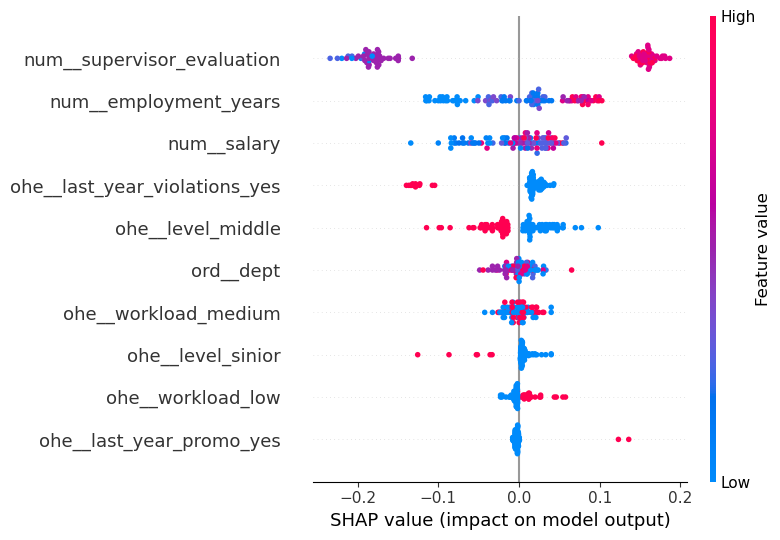

In [31]:
explainer = shap.TreeExplainer(model)

# Вычислите значения SHAP для фонового набора данных
background = shap.sample(X_train_preprocessed, 100)
SHAP_values = explainer.shap_values(background)

# Постройте сводный график SHAP
shap.summary_plot(SHAP_values, background)

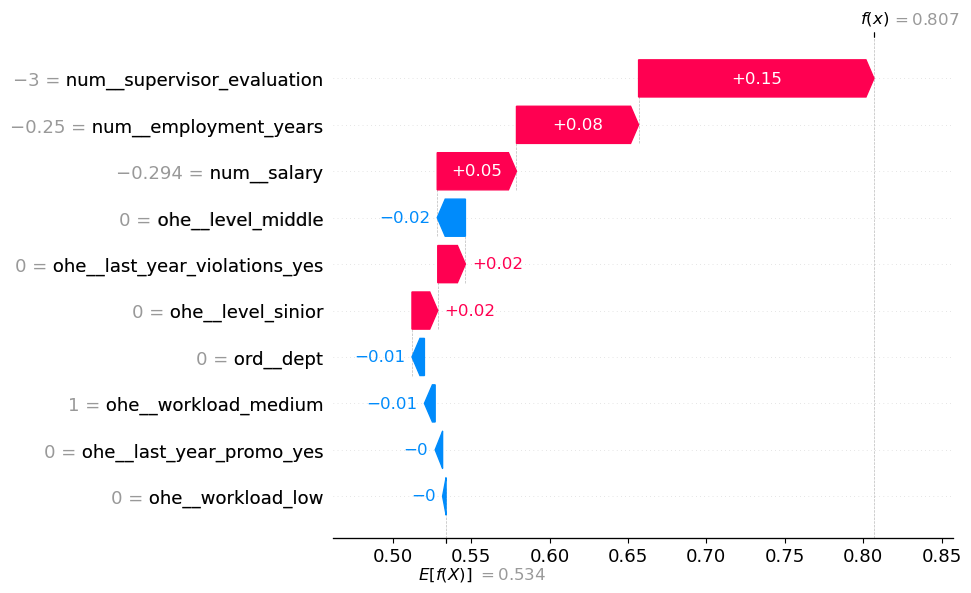

In [32]:
sample_index = 0  
shap.waterfall_plot(shap.Explanation(values=SHAP_values[6], 
                                         base_values=explainer.expected_value[0], 
                                         data=X_train_preprocessed.iloc[sample_index], 
                                         feature_names=X_train_preprocessed.columns), show=True)

- Чем больше значения признаков "supervisor_evaluation" и "salary": тем меньше SHAP‑значения объектов. Если у наблюдения высокое значение этих признаков, то у него высокая вероятность принадлежности к классу 1.

- Чем больше значение признака "level","last_year_violations": тем выше SHAP-значения. Если у наблюдения высокое значение этого признака, то у него высокая вероятность принадлежности к классу 0.

### Оформление выводов

1) Лучше всего справилась модель - DecisionTreeRegressor(max_depth=13, max_features=8, random_state=42)

2) SMAPE для тестовых данных: 14.85143967748389

- Чем больше значения признаков "supervisor_evaluation" и "salary": тем меньше SHAP‑значения объектов. Если у наблюдения высокое значение этих признаков, то у него высокая вероятность принадлежности к классу 1.

- Чем больше значение признака "level","last_year_violations": тем выше SHAP-значения. Если у наблюдения высокое значение этого признака, то у него высокая вероятность принадлежности к классу 0.

## Задача 2: предсказание увольнения сотрудника из компании

quit — увольнение сотрудника из компании.

In [33]:
try:
    #Тренировочная выборка:
    train_quit = pd.read_csv('/datasets/train_quit.csv')
    train_quit.name = 'train_quit'
    #Входные признаки тестовой выборки:
    test_features = pd.read_csv('/datasets/test_features.csv')
    test_features.name = 'test_features'
    #Целевой признак тестовой выборки:
    test_target_quit = pd.read_csv('/datasets/test_target_quit.csv')
    test_target_quit.name = 'test_target_quit'
except:
    #Тренировочная выборка:
    train_quit = pd.read_csv('train_quit.csv')
    train_quit.name = 'train_quit'
    #Входные признаки тестовой выборки:
    test_features = pd.read_csv('test_features.csv')
    test_features.name = 'test_features'
    #Целевой признак тестовой выборки:
    test_target_quit = pd.read_csv('test_target_quit.csv')
    test_target_quit.name = 'test_target_quit'

In [34]:
all_data_list2 = [train_quit,test_features,test_target_quit]

In [35]:
for i in all_data_list2:
    display(i.name)
    display(i.head())

'train_quit'

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


'test_features'

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


'test_target_quit'

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [36]:
for i in all_data_list2:
    print(i.name)
    print(' ')
    i.info()
    print(' ')

train_quit
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB
 
test_features
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 -------------

### Предобработка данных

#### Замените названия столбцов (приведите к нижнему регистру)

In [37]:
def to_lower(all_data_list2):
    for i in all_data_list2:
        i.columns = i.columns.str.lower().str.replace(' ', '_')
to_lower(all_data_list2)

#### Обработайте пропуски при необходимости

In [38]:
for i in all_data_list2:
    print(' ')
    print(i.name)
    print(' ')
    print(i.isna().sum())

 
train_quit
 
id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64
 
test_features
 
id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64
 
test_target_quit
 
id      0
quit    0
dtype: int64


Видим 3 пропуска, избавимся от них в пайплайне

#### Дубликаты

In [39]:
for i in all_data_list2:
    print(' ')
    print(i.name)
    print(' ')
    print(i.duplicated().sum())

 
train_quit
 
0
 
test_features
 
0
 
test_target_quit
 
0


In [40]:
for i in all_data_list2:
    print(' ')
    print(i.name)
    print(' ')
    for column in i.select_dtypes(include='object').columns:
        print(column)
        print(i[column].unique())

 
train_quit
 
dept
['sales' 'purchasing' 'marketing' 'technology' 'hr']
level
['middle' 'junior' 'sinior']
workload
['high' 'medium' 'low']
last_year_promo
['no' 'yes']
last_year_violations
['no' 'yes']
quit
['no' 'yes']
 
test_features
 
dept
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
level
['junior' 'middle' 'sinior' nan]
workload
['medium' 'low' 'high' ' ']
last_year_promo
['no' 'yes']
last_year_violations
['no' 'yes']
 
test_target_quit
 
quit
['yes' 'no']


In [41]:
test_features['dept'] = test_features['dept'].replace(' ',np.nan)
test_features['workload'] = test_features['workload'].replace(' ',np.nan)

Вывод:
- Привели к змеиному регистру
- Явных дубликатов - нет
- заменили значения ' ' - на nan
- Видим 10 пропусков в таблице - train_job_satisfaction_rate и 3 пропуска в test_features. Если есть пропуски, заполните их в пайплайне.

### Исследовательский анализ данных

In [42]:
train_quit.set_index('id', inplace=True)#quit - целевой признак
train_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no
814010,sales,junior,medium,2,no,no,4,27600,no
155091,purchasing,middle,medium,5,no,no,1,37200,no
257132,sales,junior,medium,2,no,yes,3,24000,yes
910140,marketing,junior,medium,2,no,no,5,25200,no


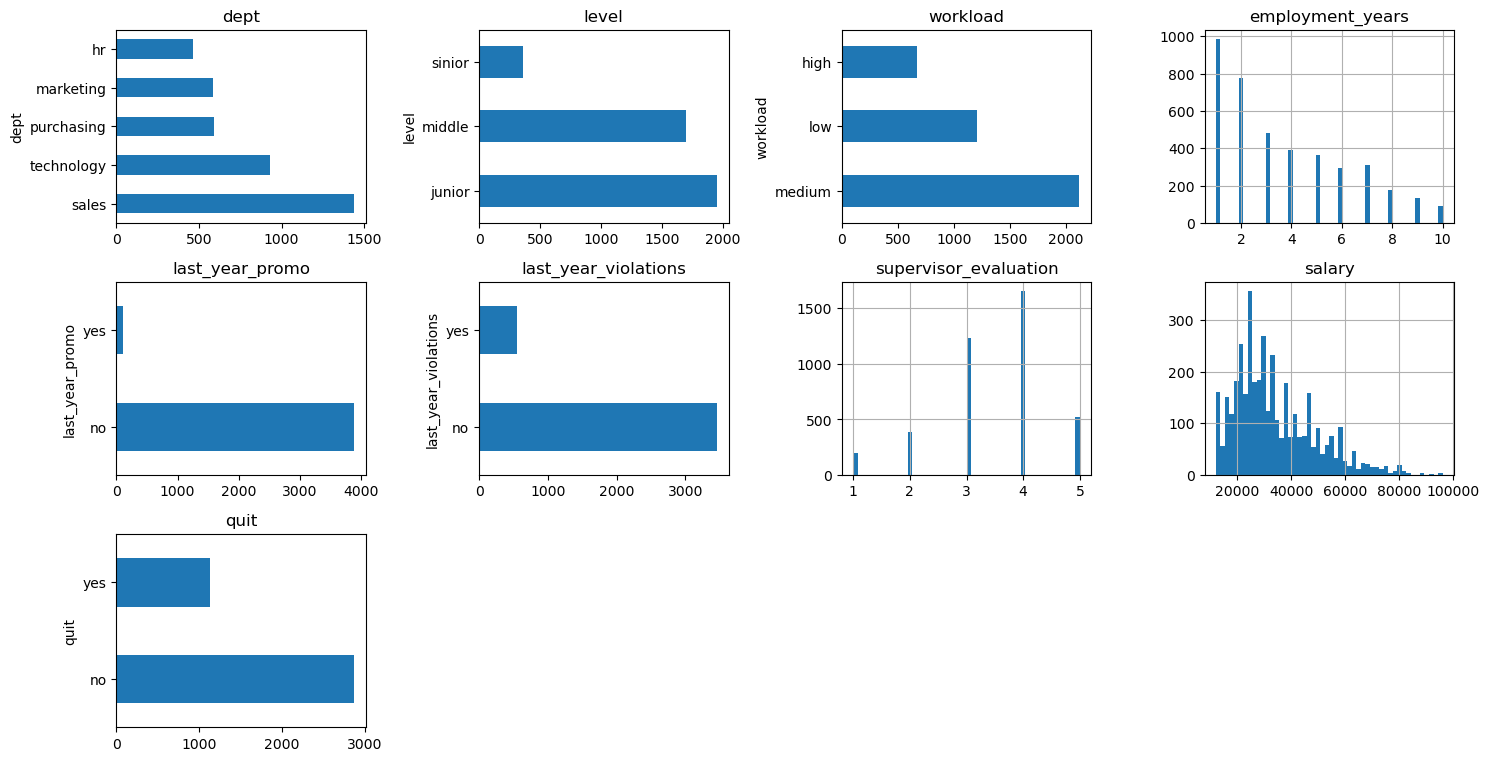

In [43]:
fig = plt.figure(figsize = (15,10))
for i, column in enumerate(train_quit.columns):
    ax = fig.add_subplot(4,4,i+1)
    if train_quit[column].dtype == 'object':
        train_quit[column].value_counts().plot(kind='barh')
        ax.set_title(column)
    else:
        train_quit[column].hist(bins = 50)
        ax.set_title(column)
plt.tight_layout()
plt.show()

Аномальных значений не видим

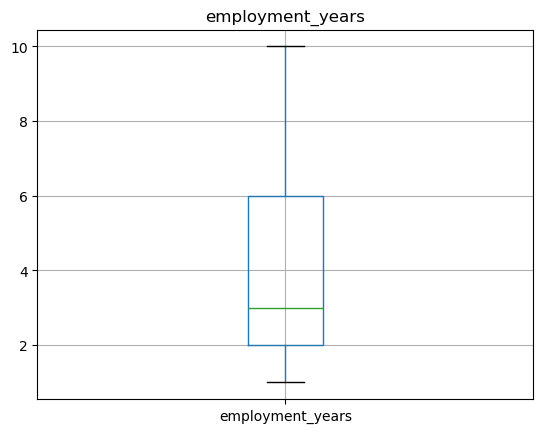

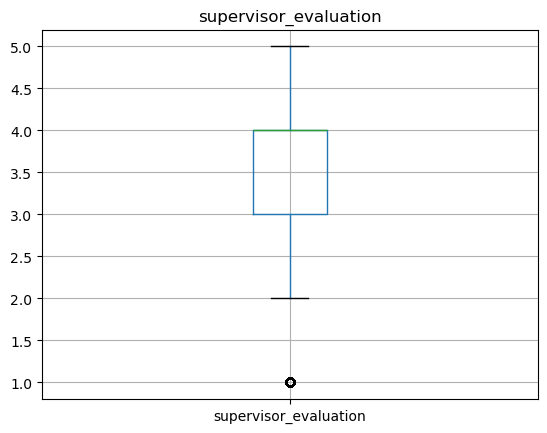

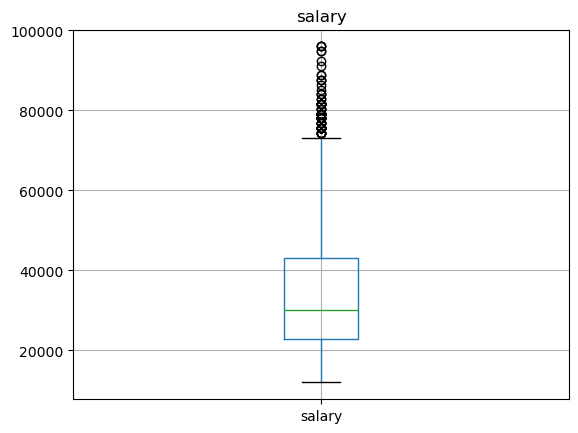

In [44]:
for column in train_quit.columns:
    if train_quit[column].dtype != 'object' :
        train_quit.boxplot(column)
        plt.title(column)
        plt.show()

In [45]:
test_features.set_index('id', inplace=True)#quit - целевой признак
test_features.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800
686555,hr,junior,medium,1,no,no,4,30000
467458,sales,middle,low,5,no,no,4,19200
418655,sales,middle,low,6,no,no,4,19200
789145,hr,middle,medium,5,no,no,5,40800


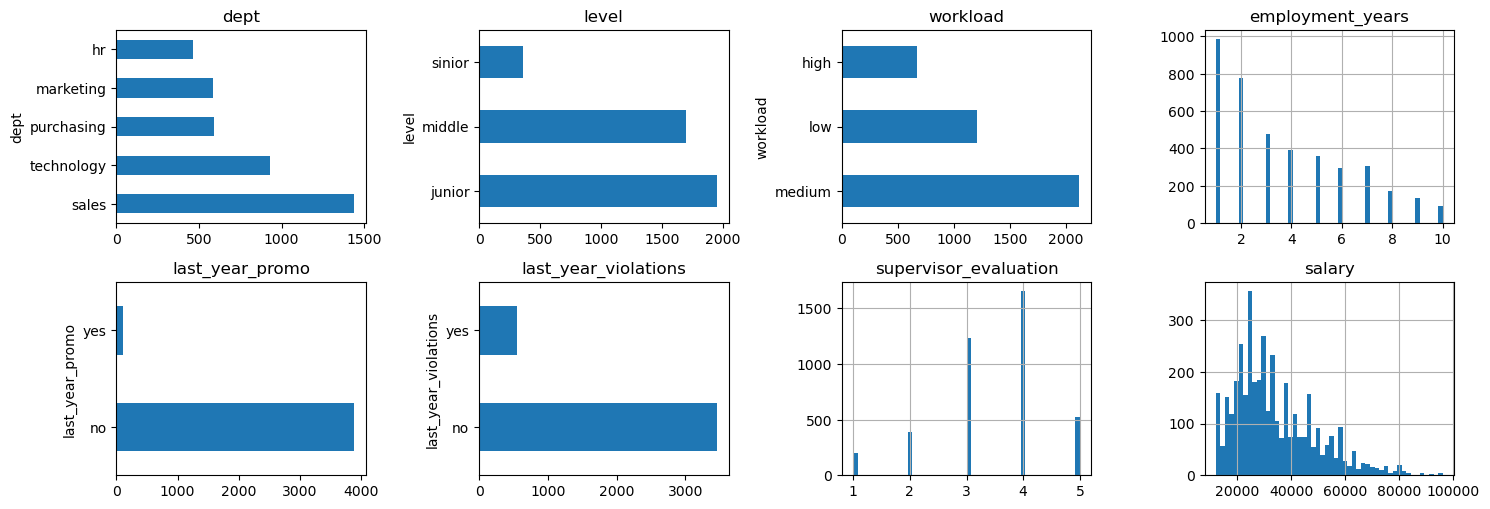

In [46]:
fig = plt.figure(figsize = (15,10))
for i, column in enumerate(test_features.columns):
    ax = fig.add_subplot(4,4,i+1)
    if train_quit[column].dtype == 'object':
        train_quit[column].value_counts().plot(kind='barh')
        ax.set_title(column)
    else:
        train_quit[column].hist(bins = 50)
        ax.set_title(column)
plt.tight_layout()
plt.show()

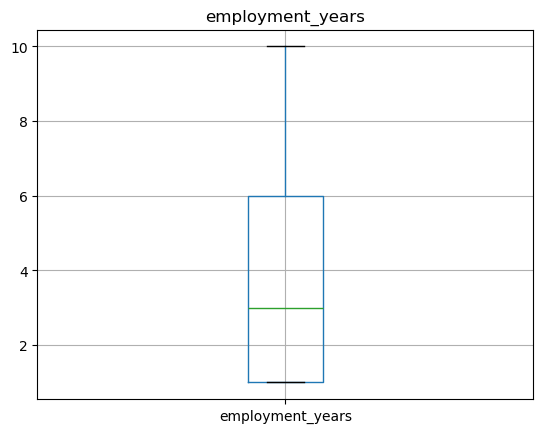

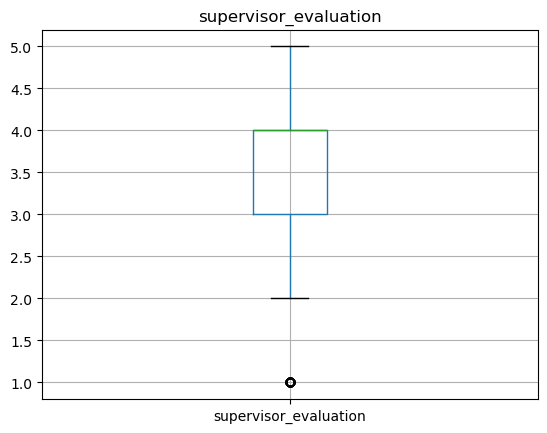

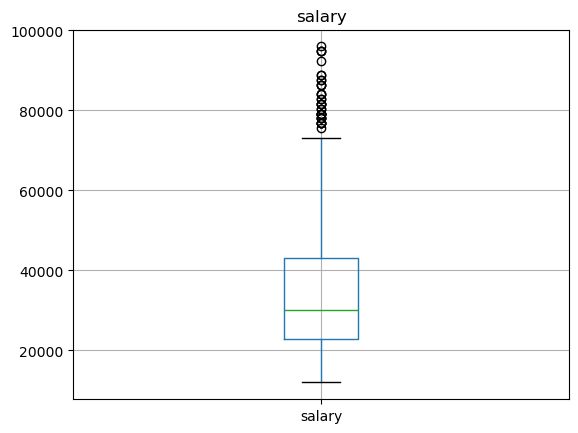

In [47]:
for column in test_features.columns:
    if test_features[column].dtype != 'object' :
        test_features.boxplot(column)
        plt.title(column)
        plt.show()

In [48]:
test_target_quit.set_index('id', inplace=True)#quit - целевой признак
test_target_quit.head()

,quit
id,
999029,yes
372846,no
726767,no
490105,no
416898,yes


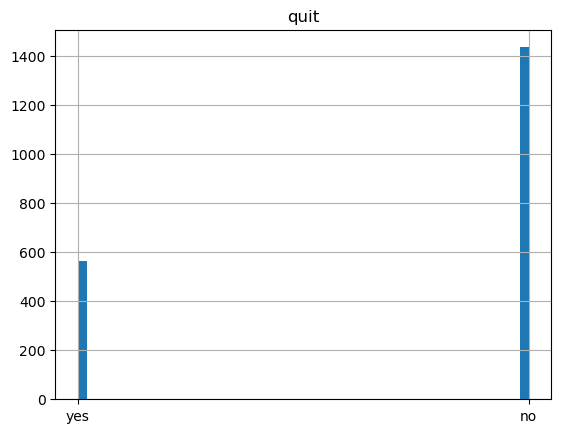

In [49]:
test_target_quit['quit'].hist(bins = 50)
plt.title('quit')
plt.show()

Вывод:
- нет аномальных значений ни в одной из таблиц

**2) Составьте портрет «уволившегося сотрудника». Например, можно узнать, в каком отделе с большей вероятностью работает уволившийся сотрудник и какой у него уровень загруженности. Также можно сравнить среднее значение зарплаты ушедших сотрудников с теми, кто остался в компании.**


In [50]:
train_quit_yes = train_quit[train_quit['quit'] == 'yes']# уволившийся сотрудник
train_quit_no = train_quit[train_quit['quit'] == 'no']# оставшийся сотрудник
train_quit_yes['workload'].value_counts()

workload
low       519
medium    488
high      121
Name: count, dtype: int64

Уровень загруженности сотрудника - у уволившихся сотрудников чаще всего - low(маленькая)

In [51]:
train_quit_yes['dept'].value_counts()

dept
sales         407
technology    276
purchasing    166
marketing     163
hr            116
Name: count, dtype: int64

Чаще всего уволивщиеся сотрудники работали в отделе продаж

In [52]:
print('Уволились:', train_quit_yes['salary'].mean(), '\n',
'Остались', train_quit_no['salary'].mean(), '\n', 
'Разница:', train_quit_no['salary'].mean() - train_quit_yes['salary'].mean())

Уволились: 23885.106382978724 
 Остались 37702.22841225627 
 Разница: 13817.122029277547


Среднее значение заработка людей, которые уволились меньше, чем те, которые остались на 13817.122029277547

In [53]:
'Уволились:',len(train_quit_yes)/len(train_quit['quit']),'Остались',len(train_quit_no)/len(train_quit['quit'])

('Уволились:', 0.282, 'Остались', 0.718)

Общая доля уволившихся сотрудников: 0.282

In [54]:
data = []
for dept in train_quit['dept'].unique().tolist():
    quit_rate = len(train_quit_yes[train_quit_yes['dept'] == dept]) / len(train_quit[train_quit['dept'] == dept])
    stay_rate = len(train_quit_no[train_quit_no['dept'] == dept]) / len(train_quit[train_quit['dept'] == dept])
    data.append([dept, quit_rate, stay_rate])
df = pd.DataFrame(data, columns=['Отдел', 'Доля уволившихся', 'Доля оставшихся'])
df

,Отдел,Доля уволившихся,Доля оставшихся
0,sales,0.283032,0.716968
1,purchasing,0.282313,0.717687
2,marketing,0.280069,0.719931
3,technology,0.297414,0.702586
4,hr,0.250000,0.750000


Портрет «уволившегося сотрудника»:
- Уровень загруженности сотрудника - у уволившихся сотрудников чаще всего - low(маленькая)
- Чаще всего уволившиеся сотрудники работали в отделе продаж
- С зарплатой меньше, чем у действующих сотрудников(Среднее значение заработка людей, которые уволились меньше, чем те, которые остались на 13817.122029277547)
- Общая доля уволившихся сотрудников: 0.282


 |Отдел	| Доля уволившихся|	Доля оставшихся|
|-----------|-----------|-----------|
|sales|	    0.283032|	0.716968|
|purchasing|	0.282313|	0.717687|
|marketing|	0.280069|	0.719931|
|technology|	0.297414|	0.702586|
|hr|	        0.250000|	0.750000|


3) Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Проверьте это утверждение: визуализируйте и сравните распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников. Используйте данные с обоими целевыми признаками тестовой выборки.

In [55]:
quit_job_satisfaction_rate = pd.merge(test_target_quit,test_target_job_satisfaction_rate, on='id')
quit_job_satisfaction_rate_yes = quit_job_satisfaction_rate[quit_job_satisfaction_rate['quit'] == 'yes']
# уволившийся сотрудник
quit_job_satisfaction_rate_no = quit_job_satisfaction_rate[quit_job_satisfaction_rate['quit'] == 'no']
# оставшийся сотрудник

Уволившийся сотрудник и удовлетворенность от работы

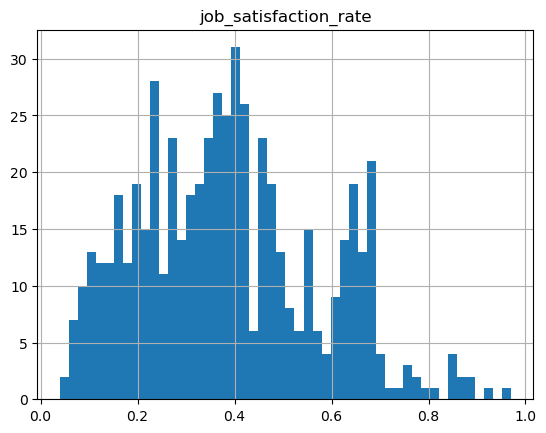

In [56]:
quit_job_satisfaction_rate_yes['job_satisfaction_rate'].hist(bins = 50)
plt.title('job_satisfaction_rate')
plt.show()

Чаще всего уволившиеся сотрудники недовольны работой

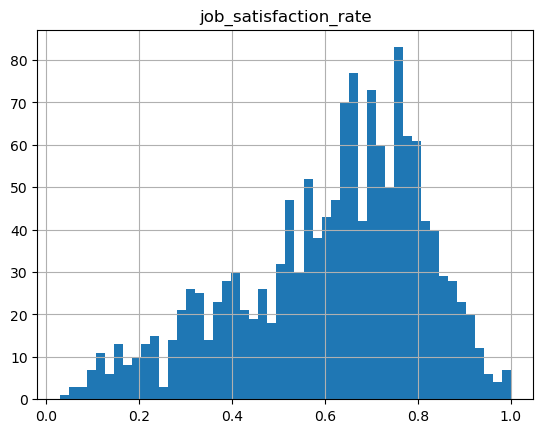

In [57]:
quit_job_satisfaction_rate_no['job_satisfaction_rate'].hist(bins = 50)
plt.title('job_satisfaction_rate')
plt.show()

Чаще всего уволившиеся сотрудники довольны работой

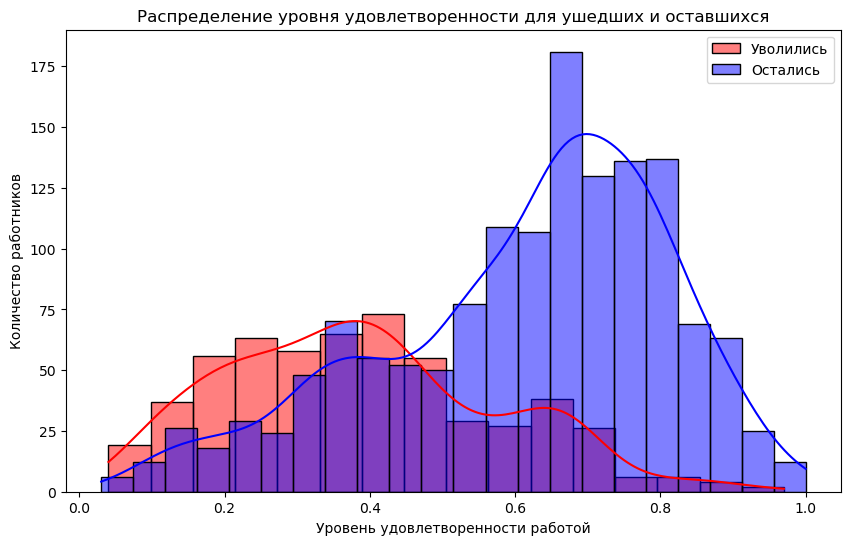

In [58]:
# Визуализация распределений
plt.figure(figsize=(10, 6))
sns.histplot(x='job_satisfaction_rate', data=quit_job_satisfaction_rate_yes, label='Уволились', color='red', kde=True)
sns.histplot(x='job_satisfaction_rate', data=quit_job_satisfaction_rate_no, label='Остались', color='blue', kde=True)
plt.xlabel('Уровень удовлетворенности работой')
plt.ylabel('Количество работников')
plt.title('Распределение уровня удовлетворенности для ушедших и оставшихся')
plt.legend()
plt.show()


In [59]:
import scipy.stats as stats

# Статистический тест (например, тест Стьюдента)
statistic, pvalue = stats.ttest_ind(quit_job_satisfaction_rate_yes[
    'job_satisfaction_rate'], quit_job_satisfaction_rate_no['job_satisfaction_rate'])

# Вывод результатов
print(f"Статистика теста: {statistic}")
print(f"P-значение: {pvalue}")

# Интерпретация:
if pvalue < 0.05:
    print("Существенная разница в распределениях уровня удовлетворенности между ушедшими и оставшимися работниками.")
else:
    print("Нет существенной разницы в распределениях уровня удовлетворенности.")

Статистика теста: -23.074784903634527
P-значение: 1.2311220665173681e-104
Существенная разница в распределениях уровня удовлетворенности между ушедшими и оставшимися работниками.


**Вывод:**
Портрет «уволившегося сотрудника»:
- Уровень загруженности сотрудника - у уволившихся сотрудников чаще всего - low(маленькая)
- Чаще всего уволившиеся сотрудники работали в отделе продаж
- С зарплатой меньше, чем у действующих сотрудников
- Общая доля уволившихся сотрудников: 0.282


 |Отдел	| Доля уволившихся|	Доля оставшихся|
|-----------|-----------|-----------|
|sales|	    0.283032|	0.716968|
|purchasing|	0.282313|	0.717687|
|marketing|	0.280069|	0.719931|
|technology|	0.297414|	0.702586|
|hr|	        0.250000|	0.750000|

Уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник:

- Чаще всего уволившиеся сотрудники недовольны работой
- Чаще всего уволившиеся сотрудники довольны работой
____
- Существенная разница в распределениях уровня удовлетворенности между ушедшими и оставшимися работниками.

### Добавление нового входного признака


- Допустим, job_satisfaction_rate и quit действительно связаны и вы получили необходимое значение метрики в первой задаче. 
- Тогда добавьте job_satisfaction_rate, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.

Если мы выше используем поли, то тогда кол- во не совпадает 

In [60]:
test_features['job_satisfaction_rate'] = y_test_pred

# Извлекаем шаги предобработки и моделирования из лучшего пайплайна
best_pipeline = randomized_search.best_estimator_
preprocessor = best_pipeline.named_steps['preprocessor']
model = best_pipeline.named_steps['models']
X_train_preprocessed = preprocessor.transform(X_train)
y_pred_train = model.predict(X_train_preprocessed)

train_quit['job_satisfaction_rate'] = y_pred_train
train_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no,0.495000
814010,sales,junior,medium,2,no,no,4,27600,no,0.763333
155091,purchasing,middle,medium,5,no,no,1,37200,no,0.140000
257132,sales,junior,medium,2,no,yes,3,24000,yes,0.386667
910140,marketing,junior,medium,2,no,no,5,25200,no,0.176250


### Корреляционный анализ 

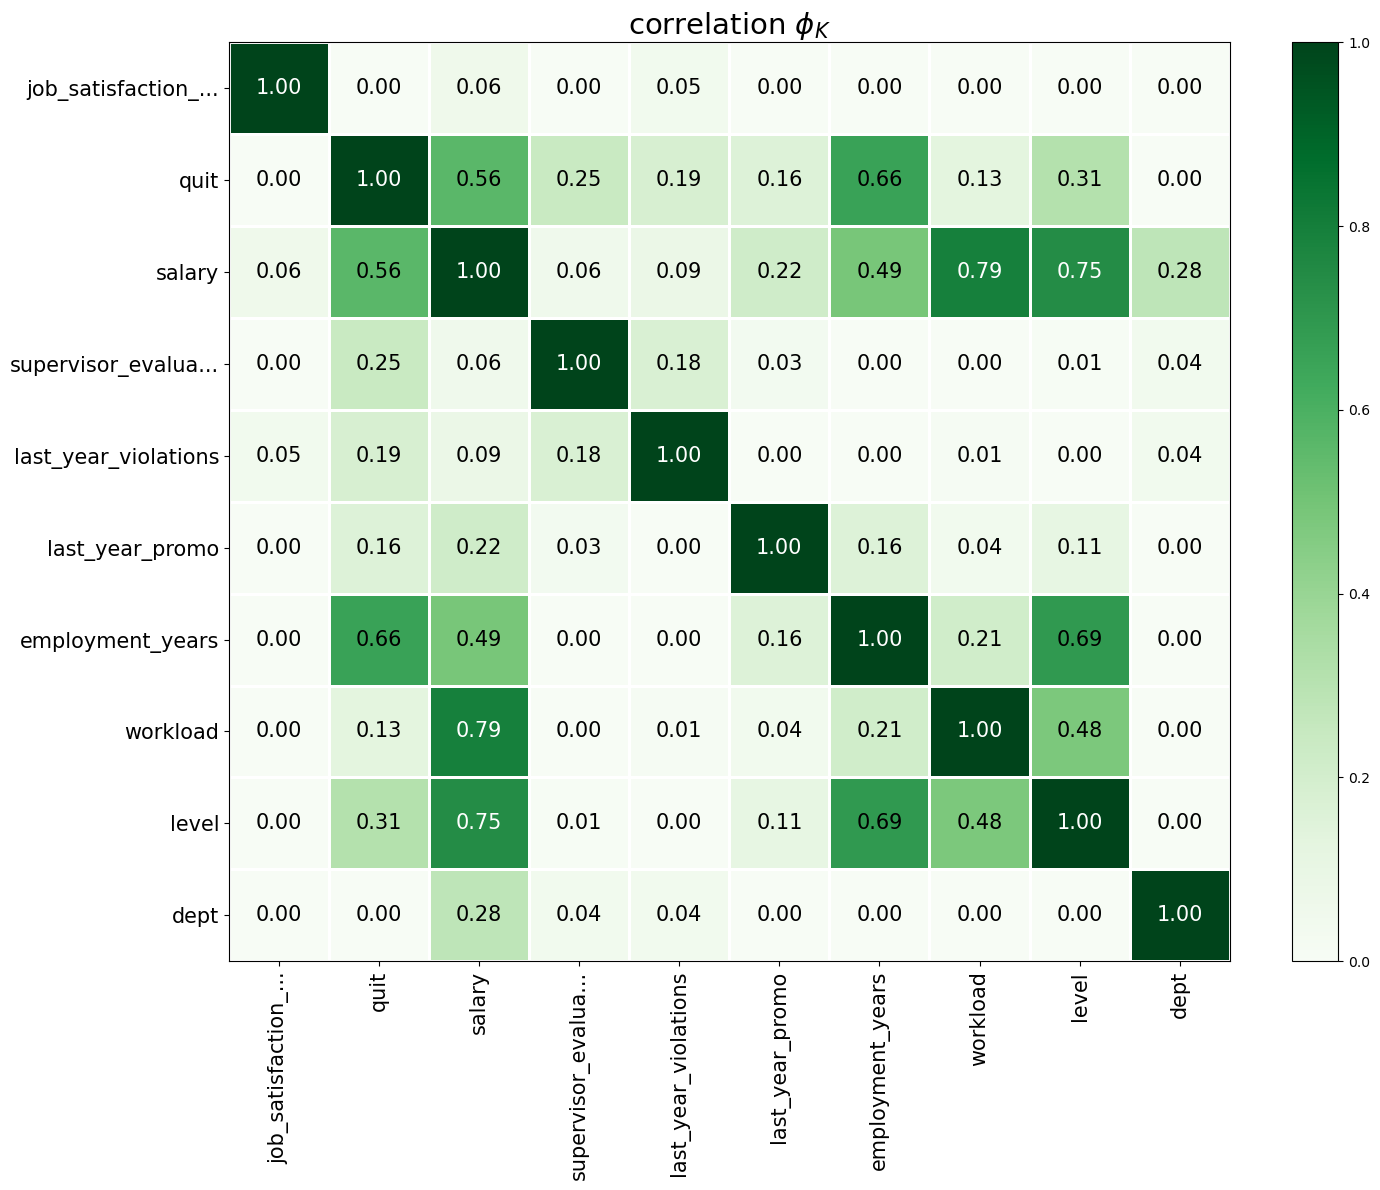

In [61]:
interval_cols = train_quit.select_dtypes(include = ['int','float'])

phik_overview = train_quit.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    vmin=0, vmax=1, color_map='Greens',
    fontsize_factor=1.5,
    figsize=(15, 12)
)

Мультиколлинеарности нет

### Подготовка данных

In [62]:
RANDOM_STATE = 42

X_train = train_quit.drop(['quit'], axis=1)
y_train = train_quit['quit']

test2 = test_features.merge(test_target_quit,on = 'id')
X_test = test2.drop(['quit'], axis = 1)
y_test = test2['quit']

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Создаём списки с названиями признаков
ohe_columns = [col for col in X_train.select_dtypes(include = 'object').columns.tolist() if (col != 'dept')]
ord_columns = ['dept']
num_columns = [col for col in X_train.select_dtypes(include = ['int','float']).columns.tolist() if (col != 'dept')]

# Создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     
      ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore',sparse_output= False))])

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     
     ('ord', OrdinalEncoder(categories = [['sales', 'hr', 'technology', 'purchasing', 'marketing']],
                            handle_unknown='use_encoded_value',unknown_value = np.nan)),
     
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))])

# Создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)], remainder='passthrough')

# Создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('poly', PolynomialFeatures(degree=2)),
    ('models', KNeighborsClassifier())])

param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 15),
        'models__max_features': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,15),
        'models__p': [1, 2],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
    #{
    #    'models': [SVC(random_state=RANDOM_STATE, probability=True)],
    #    'models__C': [0.1, 1, 10],
    #    'models__kernel': ['linear', 'rbf','sigmoid'],
    #    'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    #},
    {
       'models': [GradientBoostingClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [200, 250, 300], 
        'models__learning_rate': [0.1, 0.01],
        'models__max_depth': range(2, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    #{
    #    'models': [AdaBoostClassifier(random_state=RANDOM_STATE)],
    #    'models__n_estimators': [50, 100, 200], 
    #    'models__learning_rate': [0.1, 0.01],
    #    'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    #},
    #{
    #    'models': [GaussianNB()],
    #    'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    #}
]

### Обучение модели

In [63]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

y_test_pred2 = randomized_search.predict_proba(X_test)

print('Площадь ROC-кривой:', roc_auc_score(y_test, y_test_pred2[:, 1]))#


Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['level', 'workload',
                                                   'last_year_promo',
                                                   'last_year_violations']),
                     

In [64]:
results_df = pd.DataFrame(randomized_search.cv_results_).sort_values(by='rank_test_score').set_index('params')
results_df.iloc[:, 4:]

,param_preprocessor__num,param_models__max_features,param_models__max_depth,param_models,param_models__n_estimators,param_models__learning_rate,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
params,,,,,,,,,,,,,,
"{'preprocessor__num': RobustScaler(), 'models__n_estimators': 200, 'models__max_depth': 4, 'models__learning_rate': 0.01, 'models': GradientBoostingClassifier(random_state=42)}",RobustScaler(),NaN,4,GradientBoostingClassifier(random_state=42),200.0,0.01,0.922485,0.936309,0.925831,0.930383,0.947558,0.932513,0.008837,1
"{'preprocessor__num': RobustScaler(), 'models__max_features': 12, 'models__max_depth': 6, 'models': DecisionTreeClassifier(random_state=42)}",RobustScaler(),12.0,6,DecisionTreeClassifier(random_state=42),NaN,NaN,0.893975,0.894508,0.906374,0.911713,0.898234,0.900961,0.006968,2
"{'preprocessor__num': RobustScaler(), 'models__max_features': 6, 'models__max_depth': 11, 'models': DecisionTreeClassifier(random_state=42)}",RobustScaler(),6.0,11,DecisionTreeClassifier(random_state=42),NaN,NaN,0.876046,0.894292,0.866571,0.859745,0.874079,0.874146,0.011613,3
"{'preprocessor__num': RobustScaler(), 'models__max_features': 4, 'models__max_depth': 6, 'models': DecisionTreeClassifier(random_state=42)}",RobustScaler(),4.0,6,DecisionTreeClassifier(random_state=42),NaN,NaN,0.883038,0.845963,0.868845,0.861121,0.864636,0.864720,0.011978,4
"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 12, 'models__max_depth': 10, 'models': DecisionTreeClassifier(random_state=42)}",MinMaxScaler(),12.0,10,DecisionTreeClassifier(random_state=42),NaN,NaN,0.864348,0.840070,0.877613,0.875713,0.863807,0.864310,0.013378,5
"{'preprocessor__num': RobustScaler(), 'models__max_features': 10, 'models__max_depth': 3, 'models': DecisionTreeClassifier(random_state=42)}",RobustScaler(),10.0,3,DecisionTreeClassifier(random_state=42),NaN,NaN,0.846516,0.830721,0.837081,0.849920,0.855647,0.843977,0.008958,6
"{'preprocessor__num': RobustScaler(), 'models__max_features': 3, 'models__max_depth': 4, 'models': DecisionTreeClassifier(random_state=42)}",RobustScaler(),3.0,4,DecisionTreeClassifier(random_state=42),NaN,NaN,0.804425,0.785863,0.837050,0.829843,0.762222,0.803881,0.027693,7
"{'preprocessor__num': 'passthrough', 'models__max_features': 11, 'models__max_depth': 2, 'models': DecisionTreeClassifier(random_state=42)}",passthrough,11.0,2,DecisionTreeClassifier(random_state=42),NaN,NaN,0.800522,0.781971,0.787584,0.793330,0.817578,0.796197,0.012334,8
"{'preprocessor__num': RobustScaler(), 'models__max_features': 6, 'models__max_depth': 3, 'models': DecisionTreeClassifier(random_state=42)}",RobustScaler(),6.0,3,DecisionTreeClassifier(random_state=42),NaN,NaN,0.761963,0.767080,0.767206,0.775281,0.782473,0.770801,0.007227,9


'preprocessor__num': StandardScaler(), 'models__n_estimators': 200, 'models__max_depth': 5, 'models__learning_rate': 0.1, 'models': GradientBoostingClassifier(max_depth=5, n_estimators=200, random_state=42)

Площадь ROC-кривой: 0.9224525375847014

### Важность признаков

In [65]:
best_pipeline = randomized_search.best_estimator_
preprocessor = best_pipeline.named_steps['preprocessor']
model = best_pipeline.named_steps['models']
preprocessor_col = preprocessor.get_feature_names_out()

# Применяем шаги предобработки к обучающим данным
X_train_preprocessed = preprocessor.transform(X_train)
X_train_preprocessed = pd.DataFrame(X_train_preprocessed,columns = preprocessor_col)

# Выполняем перестановку признаков
result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=RANDOM_STATE)

# Сортируем по убыванию среднего значения важности
sorted_idx = result.importances_mean.argsort()[::-1]

# Выводим результаты
print("Важность признаков по перестановке:")
for i in sorted_idx:
    col = X_test.columns[i]
    corr = result.importances_mean[i]
    print(f"{col}: {corr:.4f}") 

Важность признаков по перестановке:
level: 0.0411
job_satisfaction_rate: 0.0000
last_year_promo: -0.0156
dept: -0.0305
workload: -0.0405
last_year_violations: -0.0470
salary: -0.1242
employment_years: -0.1482
supervisor_evaluation: -0.2968


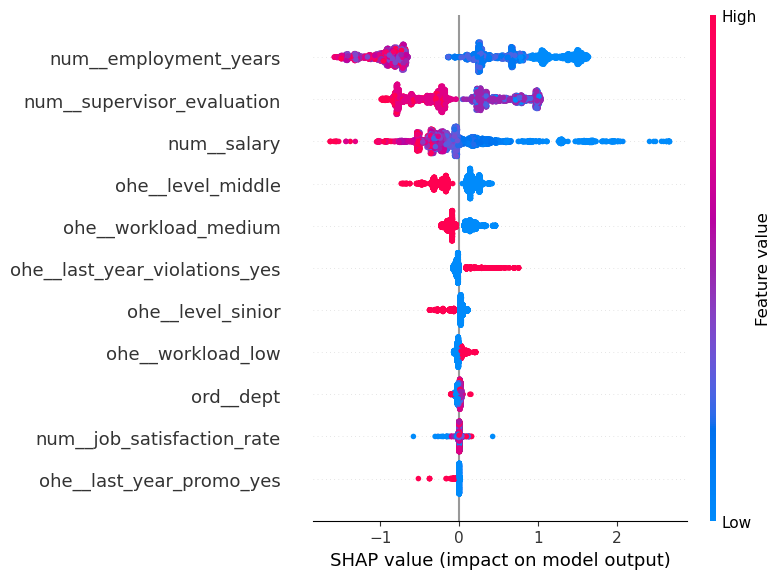

In [66]:
model.fit(X_train_preprocessed, y_train)

# Создание экземпляра Explainer
explainer = shap.TreeExplainer(model)

# Вычисление SHAP значений
shap_values = explainer.shap_values(X_train_preprocessed)

# Построение summary_plot
shap.summary_plot(shap_values, X_train_preprocessed)

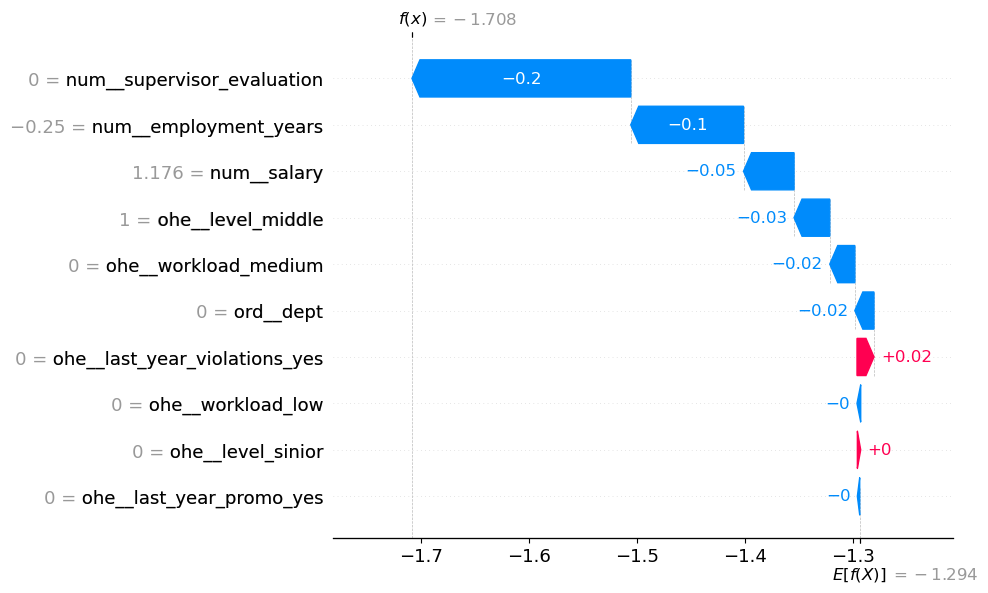

In [67]:
sample_index = 0  
shap.waterfall_plot(shap.Explanation(values=SHAP_values[3], 
                                         base_values=explainer.expected_value[0], 
                                         data=X_train_preprocessed.iloc[sample_index], 
                                         feature_names=X_train_preprocessed.columns), show=True)

- Чем больше значения признаков "last_year_violations" и "workload": тем меньше SHAP‑значения объектов. Если у наблюдения высокое значение этих признаков, то у него высокая вероятность принадлежности к классу 1.

- Чем больше значение признака "employment_years","supervisor_evaluation": тем выше SHAP-значения. Если у наблюдения высокое значение этого признака, то у него высокая вероятность принадлежности к классу 0.

### Оформление выводов

1) Лучшая модель
- 'preprocessor__num': StandardScaler(), 'models__n_estimators': 200, 'models__max_depth': 5, 'models__learning_rate': 0.1, 'models': GradientBoostingClassifier(max_depth=5, n_estimators=200, random_state=42)
- Площадь ROC-кривой: 0.9224525375847014

2) Анализ shap

- Чем больше значения признаков "last_year_violations" и "workload": тем меньше SHAP‑значения объектов. Если у наблюдения высокое значение этих признаков, то у него высокая вероятность принадлежности к классу 1.

- Чем больше значение признака "employment_years","supervisor_evaluation": тем выше SHAP-значения. Если у наблюдения высокое значение этого признака, то у него высокая вероятность принадлежности к классу 0.

### Выводы

**Задача 1:**

1. Предобработка данных

- Привели к змеиному регистру
- Явных дубликатов - нет
- заменили значения ' ' - на nan
- Видим 10 пропусков в таблице - train_job_satisfaction_rate и 3 пропуска в test_features. Если есть пропуски, заполните их в пайплайне.

2. Исследовательский анализ

- аномальных значений - нет
- используем ohe,ord - для dept
- для num и float - StandardScaler(), MinMaxScaler(),RobustScaler()

3. Корреляционный анализ

- Мультиколлинеарности нет

4. Обучение модели

1) Лучше всего справилась модель - DecisionTreeRegressor(max_depth=13, max_features=8, random_state=42)

2) SMAPE для тестовых данных: 14.85143967748389

- Чем больше значения признаков "supervisor_evaluation" и "salary": тем меньше SHAP‑значения объектов. Если у наблюдения высокое значение этих признаков, то у него высокая вероятность принадлежности к классу 1.

- Чем больше значение признака "level","last_year_violations": тем выше SHAP-значения. Если у наблюдения высокое значение этого признака, то у него высокая вероятность принадлежности к классу 0.

**Задача 2:**

1. Предобработка данных

- Привели к змеиному регистру
- Явных дубликатов - нет
- заменили значения ' ' - на nan
- Видим 10 пропусков в таблице - train_job_satisfaction_rate и 3 пропуска в test_features. Если есть пропуски, заполните их в пайплайне.

2. Исследовательский анализ

- нет аномальных значений ни в одной из таблиц

Портрет «уволившегося сотрудника»:
- Уровень загруженности сотрудника - у уволившихся сотрудников чаще всего - low(маленькая)
- Чаще всего уволившиеся сотрудники работали в отделе продаж
- С зарплатой меньше, чем у действующих сотрудников
- Общая доля уволившихся сотрудников: 0.282


 |Отдел	| Доля уволившихся|	Доля оставшихся|
|-----------|-----------|-----------|
|sales|	    0.283032|	0.716968|
|purchasing|	0.282313|	0.717687|
|marketing|	0.280069|	0.719931|
|technology|	0.297414|	0.702586|
|hr|	        0.250000|	0.750000|

Уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник:

- Чаще всего уволившиеся сотрудники недовольны работой
- Чаще всего уволившиеся сотрудники довольны работой
- Существенная разница в распределениях уровня удовлетворенности между ушедшими и оставшимися работниками.

3. Корреляционный анализ

- Мультиколлинеарности нет

4. Обучение модели

1) Лучшая модель
- 'preprocessor__num': StandardScaler(), 'models__n_estimators': 200, 'models__max_depth': 5, 'models__learning_rate': 0.1, 'models': GradientBoostingClassifier(max_depth=5, n_estimators=200, random_state=42)
- Площадь ROC-кривой: 0.9224525375847014

2) Анализ shap

- Чем больше значения признаков "last_year_violations" и "workload": тем меньше SHAP‑значения объектов. Если у наблюдения высокое значение этих признаков, то у него высокая вероятность принадлежности к классу 1.

- Чем больше значение признака "employment_years","supervisor_evaluation": тем выше SHAP-значения. Если у наблюдения высокое значение этого признака, то у него высокая вероятность принадлежности к классу 0.

____
**Выводы и дополнительные предложения для бизнеса.**

1) Положительное влияние на вероятность увольнения (класс 1):

- Высокая оценка руководителя (supervisor_evaluation) - удивительно, но это может быть связано с неадекватными требованиями к сотрудникам или же с тем, что сотрудники, получившие высокую оценку, уже знают, что их увольняют.
- Высокая зарплата (salary) - возможно, компания не готова платить за высококвалифицированных сотрудников, либо увольнение связано с оптимизацией расходов.
- Высокое количество нарушений в прошлом году (last_year_violations) - логично, что сотрудники, нарушающие правила, чаще подвергаются увольнению.
- Высокая нагрузка (workload) - сотрудники, испытывающие чрезмерную нагрузку, могут увольняться из-за выгорания или отсутствия возможности справляться с работой.

2) Положительное влияние на вероятность остаться (класс 0):

- Высокий уровень (level) - сотрудники с более высоким уровнем, возможно, ценятся компанией и имеют больше возможностей для развития.
- Длительный стаж работы (employment_years) - опытные сотрудники могут быть ценными для компании, что делает их увольнение менее вероятным.
____

1. Рекомендации для бизнеса:

1) Пересмотреть систему оценок:

- Провести глубокий анализ, почему высокая оценка руководителя связана с увольнением.
- Возможно, требуется оптимизация системы оценки, чтобы она точно отражала реальную производительность.

2) Провести анализ затрат:

- Изучить связь между уровнем зарплаты и увольнением.
- Подумать о возможности пересмотра системы оплаты труда, чтобы мотивировать ценных сотрудников.

3) Улучшить систему управления нагрузкой:

- Проанализировать факторы, ведущие к чрезмерной нагрузке у сотрудников.
- Внедрить меры по оптимизации рабочего процесса, чтобы снизить стресс и выгорание.

4) Уделить внимание повышению уровня сотрудников:

- Развивать сотрудников, чтобы они могли повышать свой уровень.
- Предоставлять возможности для обучения и профессионального роста.

5) Повысить внимание к обучению сотрудников:
- Провести обучение по правилам и процедурам компании, чтобы снизить количество нарушений.

*Дополнительные предложения:*

   - Провести исследования: Проведите дополнительные исследования среди уволенных сотрудников, чтобы получить более глубокое понимание причин их увольнения.
   - Внедрить инструменты мониторинга: Использовать инструменты, которые отслеживают нагрузку сотрудников, их настроение и производительность.
